# Домашнее задание: "Детекция объектов на изображении"

ФИО: Филимонов Степан Владиславович

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели. 

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество). 
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

---

In [1419]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [1421]:
import os
import sys
import cv2
import json
import time
import torch
import random
import skimage
import warnings
import skimage.io
import torchvision
import progressbar
import skimage.color
import skimage.transform

import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from dataset import DetectionDataset
from sklearn.metrics import f1_score   
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch import no_grad, device, cuda
from mean_average_precision import MetricBuilder
from torchmetrics.classification import BinaryF1Score
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, normalize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", DEVICE)

Device is: cpu


## Выбор модели детекции для обучения

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество). 
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)

**Выбрал: самою примитивную RCNN(Regions with CNN features)**

На лекции говорили, что RCNN самая простая модель, которая работает не всегда идеально и долго. Очевидно, что сейчас RCNN использовать не рационально, но если есть возможность поиграться с моделями для детекции, то почему не попробывать, как-нибудь по новому изобрести *велосипед*

Алгоритм RCNN(Regions with CNN features): 
1. Генерируем region proposals (Selective Search)

2. Выбираем каждый регион, пропускаем через CNN, обученную для классификации изображений.
   
3. Выбираем регионы, прошедшие по порогу, и применяем Non Maximum Suppression (NMS)

Алгоритм мой реализации RCNN:

1. Для генерации region proposals алогритм предлагаю такой:
    1. Взять контур объекта
    2. Сохранить все точки контура в массив `points`
    3. Выбрать из `points` взять случайное заданное колличество `point`, которые будут центром `frame`
    4. Создать случайные `frame`, и сохранить их в массив `frames` и `coordinats`

2. На весь `frames` сделать `prediction`. CNN модель, которая будет выбрана от обстоятельств(об этом будем в блоке с моделью)

3. Применить простенький NMS, который будет объединять контуры если у них есть пересечения и большая общая площадь

## Подготовка обучающего набора данных

1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.
4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

Для начала возьмем класс `DetectionDataset`, для простого считывания всего набора данных.

После подготовим функции для того, чтобы можно было проводить вывод, наложение рамки, извлекать объекты.

Для обучения модели будем использовать размеченный датасет из которого извлечем изображения с *мячами* и просто **непересекающийся** случай кусок картинки равный размеру изображения с *мячами*.

In [1420]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, add_path):
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path + i:j for i,j in self.data_dict.items()}
        self.imgs = list(self.data_dict.keys())

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
        h, w = image.shape[:2]

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = np.asarray(boxes)
        annot = np.zeros((len(boxes), 1))
        annot = np.concatenate((boxes, annot), axis=1)

        return {'img': image, 'annot': annot}

    def __len__(self):
        return len(self.imgs)

In [1379]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 add_path = './seminar_objdet_retina_oi5_ball/')
val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                               add_path = './seminar_objdet_retina_oi5_ball/')

test_image = example_dataset[0]

Метод для отриовки большого массива изображений, чтобы было проще выводит несколько изображений за раз

In [456]:
def plot_images(images, cols=1, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    rows = int(len(images)/cols)
    for i, image in enumerate(images, 1):
        plt.subplot(cols, rows, i)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

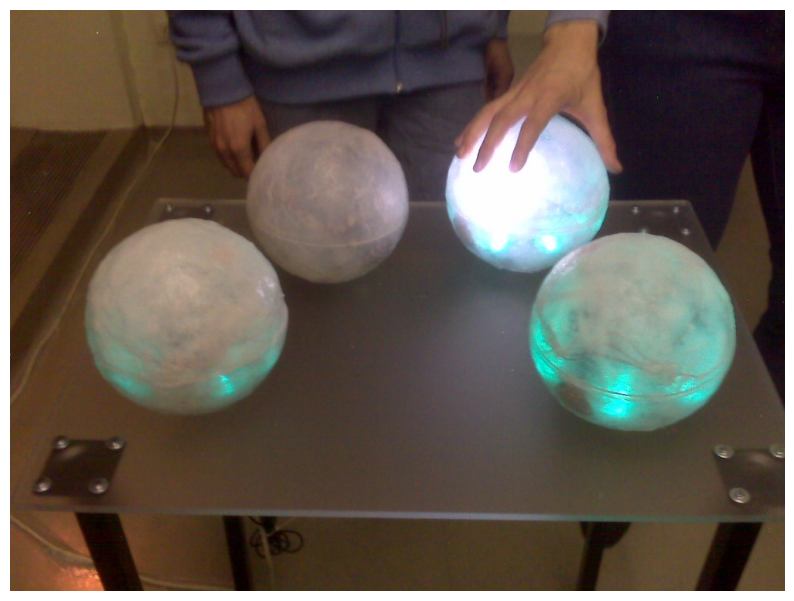

In [516]:
plot_images([test_image['img']])

В процессе отладки может возникнуть потребность в применении prediction к результату:

In [1247]:
def draw_predictions(image, bboxes):
    palette = sns.color_palette(None, 1)
    image_with_predictions = image.copy()
    for bbox in bboxes:
        x1, y1, x2, y2, *_ = bbox.astype(np.int32) if type(bbox[0]) == np.float64 else bbox
        cv2.rectangle(image_with_predictions, (x1, y1), (x2, y2), np.array(palette[0]) * 255, 2)
        
    return image_with_predictions

In [1248]:
def show_image(image_frame, figsize=(10, 10)):
    image = image_frame['img'].numpy() if type(image_frame['img']) != np.ndarray else image_frame['img']
    
    annot = image_frame['annot'].numpy() if type(image_frame['annot']) != np.ndarray else image_frame['annot']
    predictions = draw_predictions(image, annot)
    plot_images([predictions])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


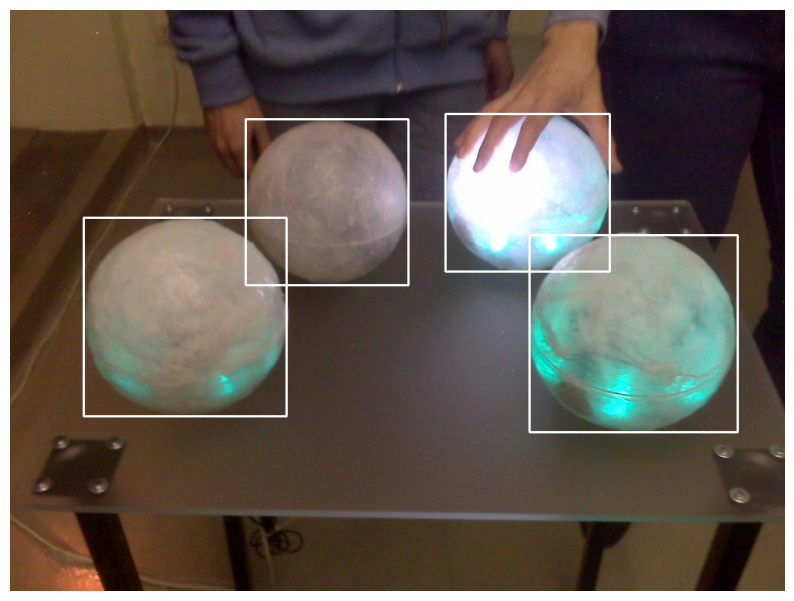

In [1249]:
show_image(test_image)

Для обучения предлагаю извлечь из всего датасета картинки с шарами и случайные изображения не пересекающаеся с шарами, одного размера. для того чтобы обучить на этих данных нейросеть

In [536]:
def get_random_coordinates(image, points, len_x, len_y):
    def _check_overlap(existing_points, new_point):
        x1, y1, x2, y2 = new_point
        for (ex1, ey1, ex2, ey2) in existing_points:
            if (x1 < ex2 and x2 > ex1 and y1 < ey2 and y2 > ey1):
                return True
        return False

    h, w = image.shape[:2]

    max_attempts = 1_000
    for attempt in range(max_attempts):
        new_x1 = random.randint(0, w - len_x)
        new_y1 = random.randint(0, h - len_y)
        new_x2 = new_x1 + len_x
        new_y2 = new_y1 + len_y

        new_point = (new_x1, new_y1, new_x2, new_y2)

        if not _check_overlap(points, new_point):
            points.append(new_point)
            return True, new_x1, new_y1, new_x2, new_y2
    return False, 0, 0, 0, 0

def extract_data(image_frame, size_randoms_noize_image=1):
    image = (image_frame['img'].numpy() if type(image_frame['img']) != np.ndarray else image_frame['img']).copy()
    bboxes = (image_frame['annot'].numpy() if type(image_frame['annot']) != np.ndarray else image_frame['annot']).copy()

    objects = {
        'value': [],
        'random': []
    }

    points = []
    for bbox in bboxes:
        x1, y1, x2, y2, _ = bbox.astype(np.int32)
        points.append((x1, y1, x2, y2))
        objects['value'].append(image[y1:y2, x1:x2])

    # На всякий случай сделаем, чтобы с запасом можно было их задать
    for _ in range(size_randoms_noize_image):
        for bbox in bboxes:
            x1, y1, x2, y2, _ = bbox.astype(np.int32)
            isSuccess, x1, y1, x2, y2 = get_random_coordinates(image, points, (x2 - x1), (y2 - y1))
            if isSuccess:
                objects['random'].append(image[y1:y2, x1:x2])
    
    return objects

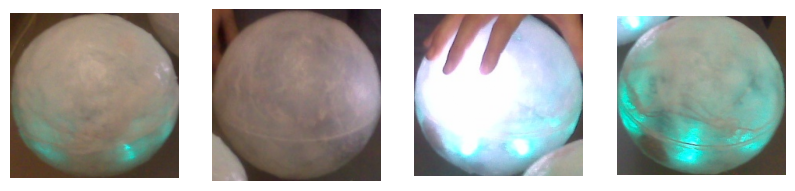

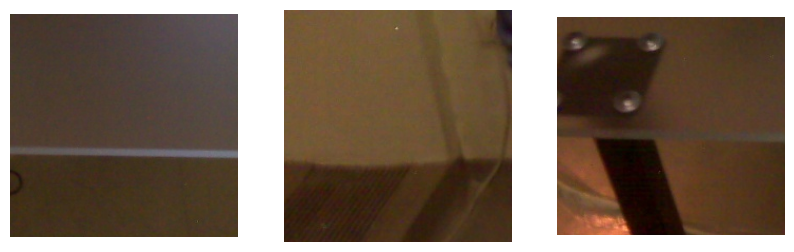

In [537]:
extracted_data = extract_data(train_dataset[2])#test_image)
plot_images(extracted_data['value'])
plot_images(extracted_data['random'])

Для обучения модели подготовим для начала датасет, извлечем все *шары* и *не шары*, после сохраним их в дериктории

### Извлечения из снимков обучающих данных и наложение на них преобразования

In [539]:
def save_image(dataset, path: str, isTrainDataSet=True, size_randoms_noize_image=1):
    def save_from_numpy(image : np.ndarray, path_to_save : str):
        image_array_normalized = (image * 255).astype(np.uint8)
        image = Image.fromarray(image_array_normalized)
        image.save(path_to_save)

    j = 1; k = 1
    for i in tqdm(range(0, len(dataset))):
        extracted_data = extract_data(dataset[i], size_randoms_noize_image)
        for ball in extracted_data['value']:
            path_to_save = (path + '/ball/' + str(j) + '.png')
            j += 1
            save_from_numpy(ball, path_to_save)
        for noBall in extracted_data['random']:
            path_to_save = (path + '/no_ball/' + str(k) + '.png')
            k += 1
            save_from_numpy(noBall, path_to_save)

In [541]:
save_image(train_dataset, path='balls/train')

100%|███████████████████████████████████████| 2875/2875 [02:16<00:00, 21.02it/s]


In [542]:
save_image(val_dataset, path='balls/val')

100%|█████████████████████████████████████████| 226/226 [00:09<00:00, 24.21it/s]


In [727]:
SHAPE = 224 if DEVICE != "cpu" else 128
data_train_dir = './balls/train'
data_val_dir = './balls/val'

# В идеале надо бы еще шум наложить, но я ограничен технически
transform = transforms.Compose([
    transforms.Resize([SHAPE, SHAPE]),
    transforms.RandomAffine(degrees=15, translate=(0.05,0.05)),
    transforms.RandomInvert(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

train_data = ImageFolder(data_train_dir, transform=transform)
test_data = ImageFolder(data_val_dir, transform=transform)

print(f'train_size = {len(train_data)}\ntest_size = {len(test_data)}')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_size = 10638
test_size = 952


Извлечены изображения для обучения модели, которая в дальнейшем будет проводить детекцию мячей

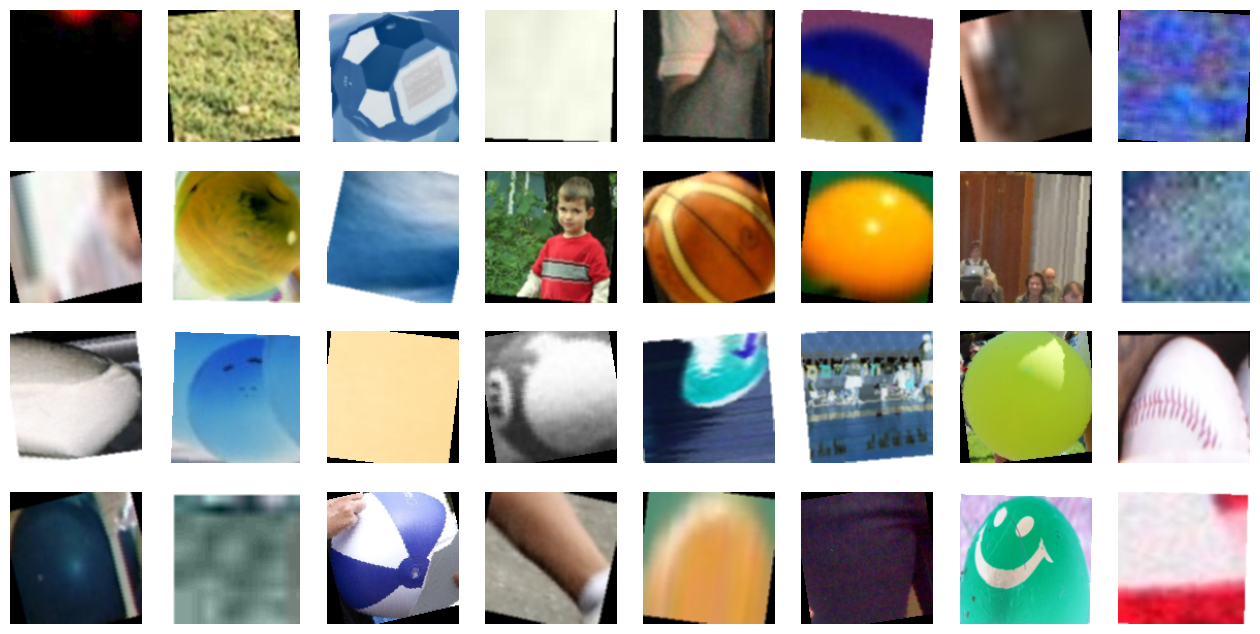

In [728]:
_image = []
buffer_images, _ = next(iter(train_loader))
for buffer_image in buffer_images:
    grid = make_grid(buffer_image, normalize=True)
    _image.append(grid.permute(1, 2, 0).numpy())
plot_images(_image, 4, figsize=(16, 8))

На фото, успешно наложились все преобразования

## Реализация корректного train-loop и обучение модели

**Задание:**

1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

В предыдущих блоках я подготовил функции для того, чтобы набрать обучающие данные, и на основе их обучим модель, на основе которой в дальнейшем будет вести классефикацию сегментов

In [729]:
def plotLAF(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs, epochs=20):
    train = [ train_loss_epochs, train_accuracy_epochs, train_f1_epochs ]
    test = [ test_loss_epochs, test_accuracy_epochs, test_f1_epochs ]
    label = [ 'Loss', 'Accuracy', 'F1' ]
    plt.figure(figsize=(12.5, 4))
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.plot(train[(i - 1)], label='Train', linewidth=1.0)
        plt.plot(test[(i - 1)], label='Test', linewidth=1.0)
        plt.xlabel('Epochs')
        plt.ylabel(label[(i - 1)])
        plt.ylim([0, 1])
        plt.xlim([0, epochs])
        plt.legend(loc=0)
        plt.grid()
    plt.show()

In [730]:
class Model:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self._f1_score = BinaryF1Score()

    def _accuracy(self, outputs, labels):
        self._pred = (outputs > 0.5).float()
        return torch.sum(self._pred == labels).item() / len(labels)

    def _f1(self, labels):
        return self._f1_score(self._pred, labels)
    
    def train(self, train_loader, test_loader, epochs, accurate_break=0.951):
        train_loss_epochs, train_accuracy_epochs, train_f1_epochs = [], [], []
        test_loss_epochs, test_accuracy_epochs, test_f1_epochs = [], [], []

        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            running_loss, running_acc, running_f1 = [], [], []
            test_loss, test_acc, test_f1 = [], [], []

            # Обучение
            self.model.train()
            for i, (inputs, labels) in enumerate(train_loader):
                labels = labels.float()

                self.optimizer.zero_grad()
                outputs = self.model(inputs).view(-1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss.append(loss.item())
                running_acc.append(self._accuracy(outputs, labels))
                running_f1.append(self._f1(labels))

            train_loss_epochs.append(np.mean(running_loss))
            train_accuracy_epochs.append(np.mean(running_acc))
            train_f1_epochs.append(np.mean(running_f1))

            # Прогон по тестовой выборке
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    labels = labels.float()

                    outputs = self.model(inputs).view(-1)
                    loss = self.criterion(outputs, labels)

                    test_loss.append(loss.item())
                    test_acc.append(self._accuracy(outputs, labels))
                    test_f1.append(self._f1(labels))

            test_loss_epochs.append(np.mean(test_loss))
            test_accuracy_epochs.append(np.mean(test_acc))
            test_f1_epochs.append(np.mean(test_f1))
        
            print(
                f'Epoch [{(epoch+1)}/{epochs}] (Train/Test) ',
                f'Loss: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}, ',
                f'Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}, ',
                f'F1: {train_f1_epochs[-1]:.3f}/{test_f1_epochs[-1]:.3f}, ',
                f't: {(time.time() - start_time):.3f} s'
            )

            if train_accuracy_epochs[-1] >= accurate_break and test_accuracy_epochs[-1] >= accurate_break:
                print('На обучающей и тестовой выборке достигли желаемого результата.\n',
                      'Чтобы не израходовать ресурсы машины:\t break')
                break

        plotLAF(
            train_loss_epochs, test_loss_epochs,
            train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs
        )
        return train_loss_epochs, test_loss_epochs, \
               train_accuracy_epochs, test_accuracy_epochs, \
               train_f1_epochs, test_f1_epochs

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs

### По поводу моделей

В качестве модели, которую буду использовать в RCNN я решил взять `VGG-16`. Но в процессе столкнулся с проблемой, что ввиду отсутствия видеокарты процесс обучения происходит слишком долго, по этому решил дополнительно взять что-то вроде `StupidCNN` - самой примитивной сверточной модели, чтобы не трать много времени на процесс обучения

#### VGG-16

##### О VGG-16

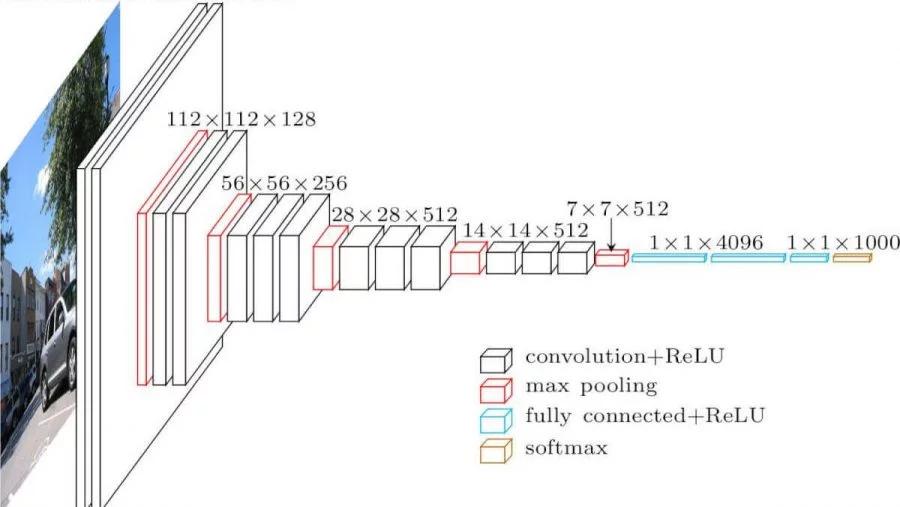

На вход слоя conv1 подаются RGB изображения размера 224х224. Далее изображения проходят через стек сверточных слоев, в которых используются фильтры с очень маленьким рецептивным полем размера 3х3 (который является наименьшим размером для получения представления о том,где находится право/лево, верх/низ, центр).

В одной из конфигураций используется сверточный фильтр размера 1х1, который может быть представлен как линейная трансформация входных каналов (с последующей нелинейностью). Сверточный шаг фиксируется на значении 1 пиксель. Пространственное дополнение (padding) входа сверточного слоя выбирается таким образом, чтобы пространственное разрешение сохранялось после свертки, то есть дополнение равно 1 для 3х3 сверточных слоев. Пространственный пулинг осуществляется при помощи пяти max-pooling слоев, которые следуют за одним из сверточных слоев (не все сверточные слои имеют последующие max-pooling). Операция max-pooling выполняется на окне размера 2х2 пикселей с шагом 2.

После стека сверточных слоев (который имеет разную глубину в разных архитектурах) идут три полносвязных слоя: первые два имеют по 4096 каналов, третий — 1000 каналов (так как в соревновании ILSVRC требуется классифицировать объекты по 1000 категориям; следовательно, классу соответствует один канал). Последним идет soft-max слой. Конфигурация полносвязных слоев одна и та же во всех нейросетях.

Все скрытые слои снабжены ReLU. Отметим также, что сети (за исключением одной) не содержат слоя нормализации (Local Response Normalisation), так как нормализация не улучшает результата на датасете ILSVRC, а ведет к увеличению потребления памяти и времени исполнения кода.

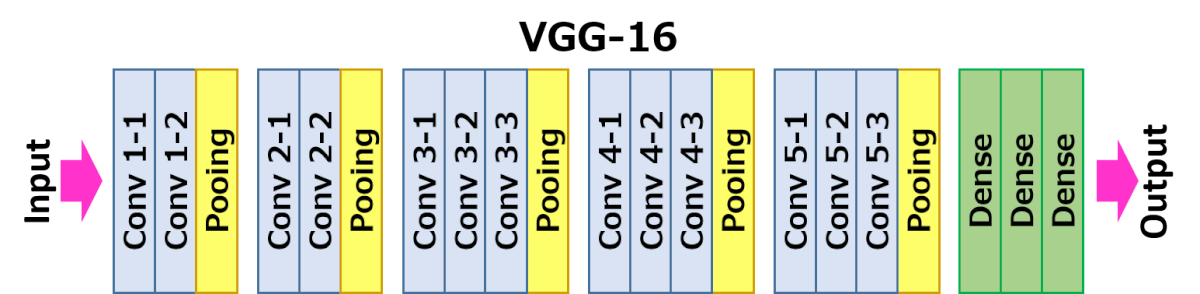

[Источник](https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/)

In [1422]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### StupidCNN

##### О StupidCNN

Просто самое  простое, что есть. Но можно еще проще. Взял из ДЗ3.

Без ведиокарты обучение очень долго происходит на VGG-16

In [732]:
class StupidCNN(nn.Module):
    def __init__(self):
        super(StupidCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

### Обучение

In [733]:
device = DEVICE
cnn = VGG16().to(device) if DEVICE != "cpu" else StupidCNN().to(device)
print(cnn) 

criterion = nn.BCELoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in cnn.parameters()])))

StupidCNN(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=16384, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)
Кол-во обучаемых параметров сети: 2120993


  5%|██▏                                         | 1/20 [01:20<25:25, 80.31s/it]

Epoch [1/20] (Train/Test)  Loss: 0.608/0.540,  Accuracy: 0.652/0.708,  F1: 0.581/0.416,  t: 80.308 s


 10%|████▍                                       | 2/20 [02:39<23:49, 79.40s/it]

Epoch [2/20] (Train/Test)  Loss: 0.518/0.479,  Accuracy: 0.740/0.792,  F1: 0.740/0.465,  t: 78.757 s


 15%|██████▌                                     | 3/20 [03:57<22:25, 79.16s/it]

Epoch [3/20] (Train/Test)  Loss: 0.464/0.411,  Accuracy: 0.786/0.819,  F1: 0.783/0.474,  t: 78.874 s


 20%|████████▊                                   | 4/20 [05:16<21:05, 79.11s/it]

Epoch [4/20] (Train/Test)  Loss: 0.415/0.572,  Accuracy: 0.815/0.755,  F1: 0.809/0.480,  t: 79.030 s


 25%|███████████                                 | 5/20 [06:34<19:40, 78.69s/it]

Epoch [5/20] (Train/Test)  Loss: 0.377/0.350,  Accuracy: 0.834/0.858,  F1: 0.829/0.469,  t: 77.945 s


 25%|███████████                                 | 5/20 [07:53<23:40, 94.71s/it]

Epoch [6/20] (Train/Test)  Loss: 0.347/0.361,  Accuracy: 0.852/0.855,  F1: 0.847/0.450,  t: 78.618 s
На обучающей и тестовой выборке достигли желаемого результата.
 Чтобы не израходовать ресурсы машины:	 break


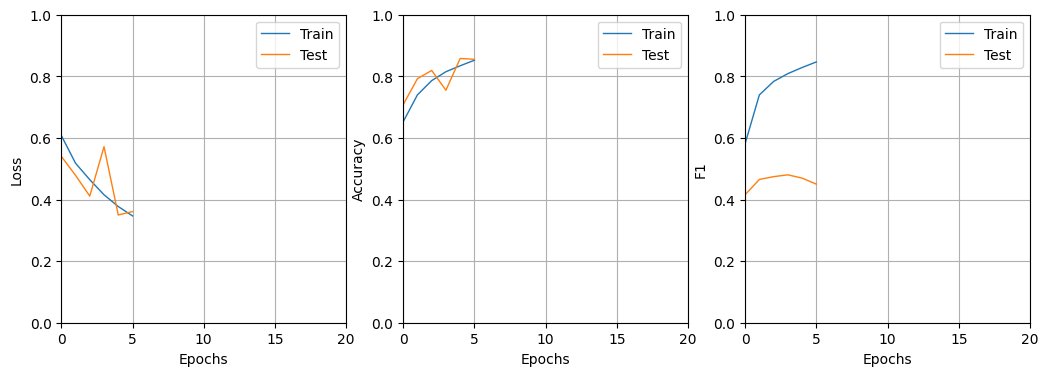

CPU times: user 34min 30s, sys: 9min 7s, total: 43min 38s
Wall time: 7min 53s


In [734]:
%%time
model = Model(cnn, criterion, optimizer)
tr_r, ts_r, tr_ac_r, ts_ac_r, tr_f1_r, ts_f1_r = model.train(train_loader, test_loader, 20, accurate_break=0.85)

На удивление значения `accuracy=0.85` было достигнуто всего за 5 эпох 

### ModelToUse

Модель для дальнешего использования, добавил вызов трансформера и его простую версию

In [1021]:
class ModelToUse:
    def __init__(self, model, transformer):
        self._model = model
        self._transformer = transformer

    def predict(self, image: np.ndarray):
        img = Image.fromarray((image * 255).astype(np.uint8), 'RGB')
        buffer = self._transformer(img)
        return self._model.predict(buffer.unsqueeze(0))

transformer = transforms.Compose([
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

cnn = ModelToUse(model, transformer)

Итак, была получена модель, которую в дальнейшем будем использовать

## Региональное разбиение снимка

In [1351]:
class RegionSplit:
    def __init__(self, model=cnn):
        self._model=model
        self._frames = {
            "img" : [],
            "annot" : [],
            "contour_points" : [],
            "center_points" : [],
            "contour" : [],
            "frames" : [],
            "coord" : [],
            "pred" : [],
            "i" : []
        }
    
    def _get_contour_from_image(self, image, coefficient=0.8):
        '''
        Опытным путем установил, что при 0.8 контур оптимальный
        '''
        image = (image > coefficient).astype(np.uint8) * 255
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
        return contour_image

    def _contour3dto2d(self, contour3d: np.ndarray):
        contour2d = np.zeros((len(contour), len(contour[0])))
        for i, rows in enumerate(contour):
            for j, value in enumerate(rows):
                contour2d[i][j] = 255 if np.mean(value) > 0 else 0
        return contour2d

    def _contour3d2points(self, contour3d: np.ndarray):
        points = []
        for i, rows in enumerate(contour):
            for j, value in enumerate(rows):
                if np.mean(value) > 0:
                    points.append((i, j))
        return np.array(points)

    def _extract_random_points(self, points, num_points):
        if num_points >= len(points):
            return points
        return points[np.random.choice(len(points), size=num_points)]

    def _extract_frames(self, points, points_size=4000, max_frames=2000, min_frame_side=10, max_frame_size=200):    
        if len(points) == 0:
            raise ValueError("Точки для извлечения frames отсутствуют")

        h, w = self._frames['img'].shape[:2]
        for point in points:
            x, y = point
            side_length = np.random.randint(min_frame_side, max_frame_size)
            x1 = np.max([int(x - side_length // 2), 0])
            y1 = np.max([int(y - side_length // 2), 0])
            x2 = np.min([int(x + side_length // 2), w])
            y2 = np.min([int(y + side_length // 2), h])        
            frame = self._frames['img'][y1:y2, x1:x2]
            if frame.shape[0] != 0 and frame.shape[1] != 0:
                self._frames['frames'].append(frame)
                self._frames['coord'].append(np.array([x1, y1, x2, y2]))

            if len(self._frames['frames']) == max_frames:
                break
        self._frames['coord'] = np.array(self._frames['coord'].copy())

    def _pred(self):
        self._frames['pred'] = np.array([float(self._model.predict(frame)[0][0]) for frame in self._frames['frames']])

    def unpackTrue(self, coef):
        if len(self._frames['pred']) == 0:
            raise ValueError('Нет предобученных значений')
 
        self._frames['i'] = np.where(self._frames['pred'] > coef)[0]
        if len(self._frames['i']) == 0:
            raise ValueError(f'При коэффиценте {coef}, значений не найдено')
        
        self._frames['true_coord'] = [self._frames['coord'][i] for i in self._frames['i']]
        self._frames['true_frames'] = [self._frames['frames'][i] for i in self._frames['i']]
        return self._frames
    
    def __call__(self, image_data, points_size=4000, max_frames=100000, min_frame_side=10, max_frame_size=200, coefficient_pred=0.99):
        image = image_data['img'].copy()
        annot = image_data['annot'].copy()

        contour = self._get_contour_from_image(image)
        contour_points = self._contour3d2points(contour)
        center_points = self._extract_random_points(contour_points, len(contour_points))
        self._frames = {
            "img" : image,
            "annot" : annot,
            "contour_points" : contour_points,
            "center_points" : center_points,
            "contour" : contour,
            "frames" : [],
            "coord" : [],
            "pred" : [],
            "i" : []
        }

        self._extract_frames(center_points, len(contour_points), max_frames, min_frame_side, max_frame_size)
        self._pred()
        
        coef = coefficient_pred
        while len(self._frames['i']) == 0:
            self._frames['i'] = np.where(self._frames['pred'] > coef)[0]
            coef -= 0.01
        coef += 0.01
        print(f'len(true_frames) = {len(self._frames["i"])}, coefficient = {coef}')

        self._frames['true_coord'] = [self._frames['coord'][i] for i in self._frames['i']]
        self._frames['true_frames'] = [self._frames['frames'][i] for i in self._frames['i']]
        return self._frames

    def drawContourTrue_framesAnnot(self):
        return [self._frames['contour'], draw_predictions(self._frames['img'], self._frames['true_coord']),
                draw_predictions(self._frames['img'], self._frames['annot'])]

rs = RegionSplit()

In [1424]:
frames = rs(val_dataset[0])

len(true_frames) = 14, coefficient = 0.98


Выведем нарезанные `frames` на экран

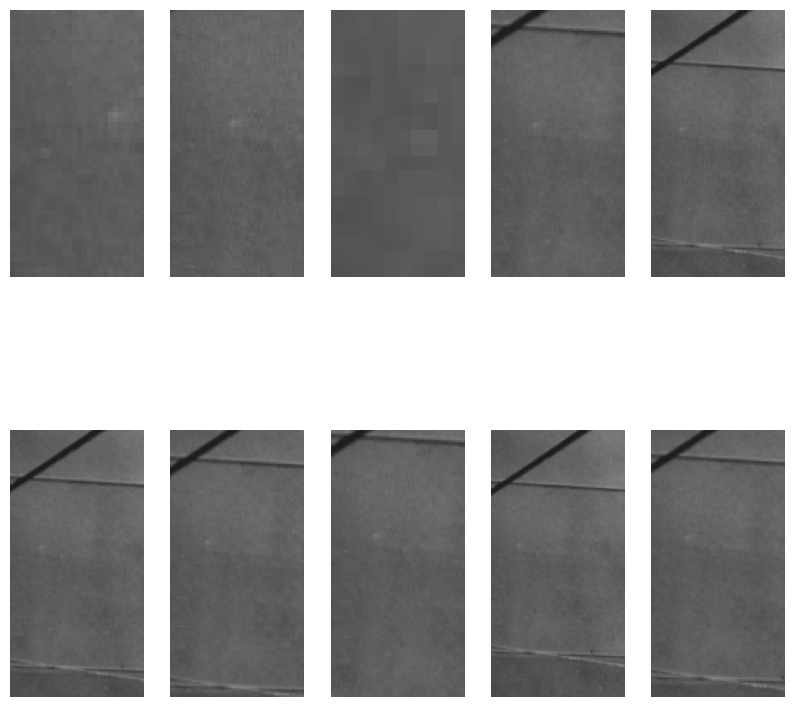

In [1425]:
plot_images(frames['frames'][:10], 2)

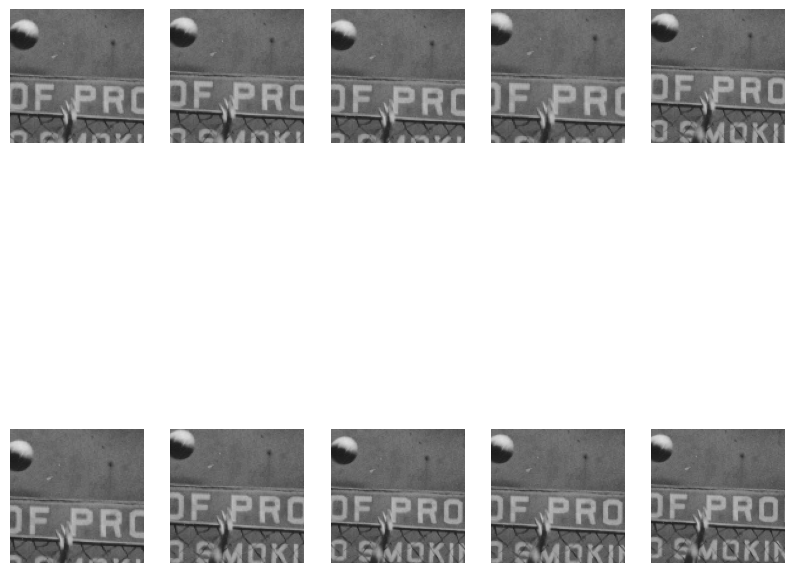

In [1426]:
plot_images(frames['true_frames'][:10], 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


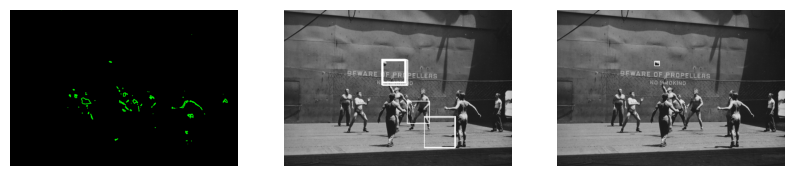

In [1427]:
plot_images(rs.drawContourTrue_framesAnnot())

Видно, что идея "в целом" рабочая, но из за того, что рамка выбирается случайно, возникает лишняя область

In [1333]:
class NonOriginalNonMaximumSuppression:
    def __init__(self):
        pass

    def _intersection_area(self, coord1, coord2):
        x1 = np.max([coord1[0], coord2[0]])
        y1 = np.max([coord1[1], coord2[1]])
        x2 = np.min([coord1[2], coord2[2]])
        y2 = np.min([coord1[3], coord2[3]])
        return ((x2 - x1) * (y2 - y1)) if x1 < x2 and y1 < y2 else 0

    def _area(self, coord):
        return ((coord[2] - coord[0]) * (coord[3] - coord[1]))

    def _combine(self, image, frames, coordinates):
        combined_frames = []
        combined_coordinates = []
        to_merge = [True] * len(frames)
    
        for i in range(len(frames)):
            if not to_merge[i]:
                continue
            current_coord = coordinates[i]
            for j in range(i + 1, len(frames)):
                if not to_merge[j]:
                    continue
                intersection = self._intersection_area(current_coord, coordinates[j])
                current_area = self._area(current_coord)
                other_area = self._area(coordinates[j])
            
                if intersection >= current_area * 0.01 or intersection >= other_area * 0.01:
                    x1 = np.min([current_coord[0], coordinates[j][0]])
                    y1 = np.min([current_coord[1], coordinates[j][1]])
                    x2 = np.max([current_coord[2], coordinates[j][2]])
                    y2 = np.max([current_coord[3], coordinates[j][3]])
                    current_coord = (x1, y1, x2, y2)
                    to_merge[j] = False
        
            combined_coordinates.append(current_coord)    
    
        for k in range(len(to_merge)):
            if to_merge[k]:
                combined_frames.append(frames[k])

        return combined_frames, combined_coordinates

    def __call__(self, frames):
        combined_frames, combined_coordinates = self._combine(frames['img'], frames['true_frames'], frames['true_coord'])
        imgWpredComb = draw_predictions(frames['img'], combined_coordinates)
        return [imgWpredComb]

nonms = NonOriginalNonMaximumSuppression()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


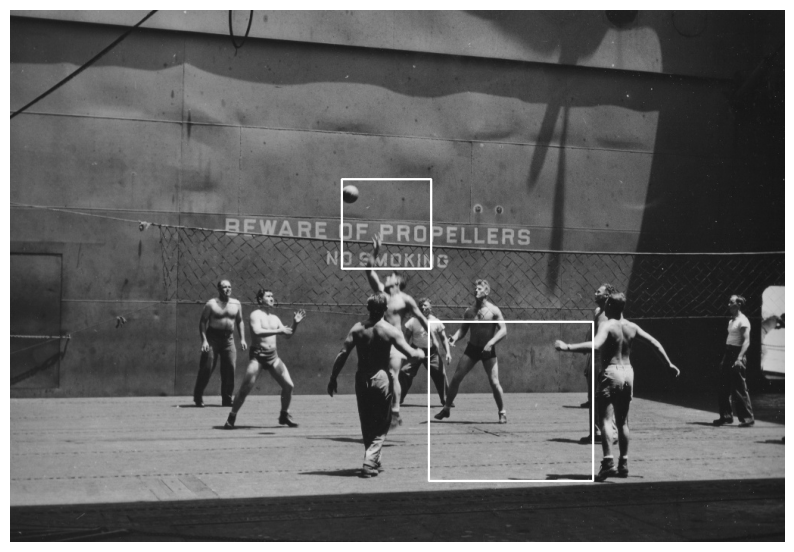

In [1428]:
plot_images(nonms(frames))

Промежуточным итогом можно сказать, что еще не все так плохо, только один не правильный объект

## Под итог

In [1404]:
def plotPred(dataframe, max_frames=100_000, pr=0.99):
    frames = RegionSplit()(dataframe, max_frame_size=max_frames, coefficient_pred=pr)
    image = draw_predictions(frames['img'], frames['annot'])
    plot_images([ NonOriginalNonMaximumSuppression()(frames)[0], image])

И так время подвести итог. Но перед этим небольшая проверка проверим как сколько `max_frames` оптиально выбирать

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


len(true_frames) = 3, coefficient = 0.98


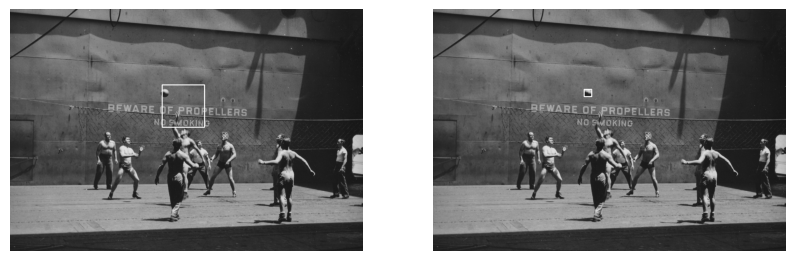

CPU times: user 11min 34s, sys: 1min 36s, total: 13min 11s
Wall time: 2min 20s


In [1405]:
%%time
plotPred(val_dataset[0], max_frames=1_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


len(true_frames) = 3, coefficient = 0.98


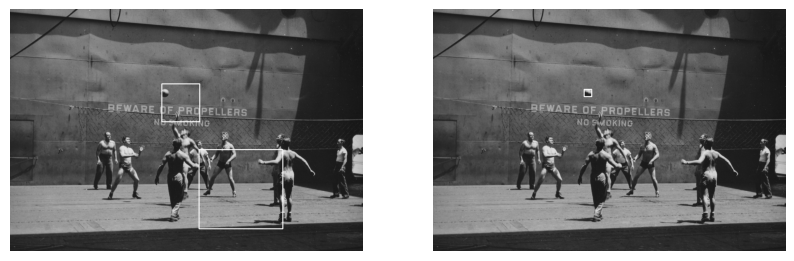

CPU times: user 16min 36s, sys: 1min 35s, total: 18min 11s
Wall time: 3min 5s


In [1406]:
%%time
plotPred(val_dataset[0], max_frames=2_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


len(true_frames) = 17, coefficient = 0.97


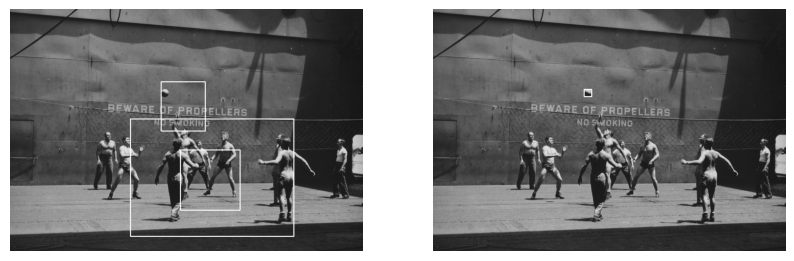

CPU times: user 17min 57s, sys: 2min 45s, total: 20min 42s
Wall time: 3min 39s


In [1407]:
%%time
plotPred(val_dataset[0], max_frames=3_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


len(true_frames) = 11, coefficient = 0.97


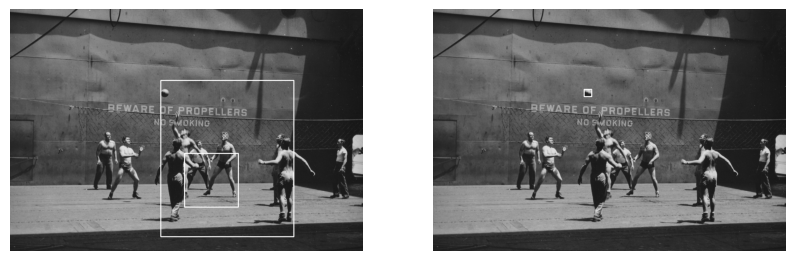

CPU times: user 17min 18s, sys: 5min 21s, total: 22min 40s
Wall time: 4min 14s


In [1408]:
%%time
plotPred(val_dataset[0], max_frames=4_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


len(true_frames) = 5, coefficient = 0.97


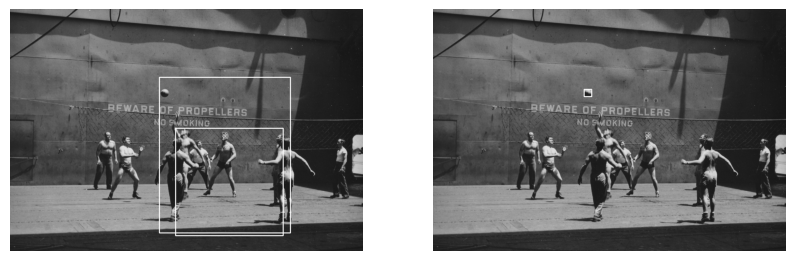

CPU times: user 17min 44s, sys: 5min 31s, total: 23min 15s
Wall time: 4min 20s


In [1409]:
%%time
plotPred(val_dataset[0], max_frames=5_000)

**По поводу** `max_frames` в целом чем больше `frame` то могут появлятся наложения, поэтому в примерах я возьму
`max_frames=1_000`

Итак визуальная оценка качества детекции

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 2, coefficient = 0.94


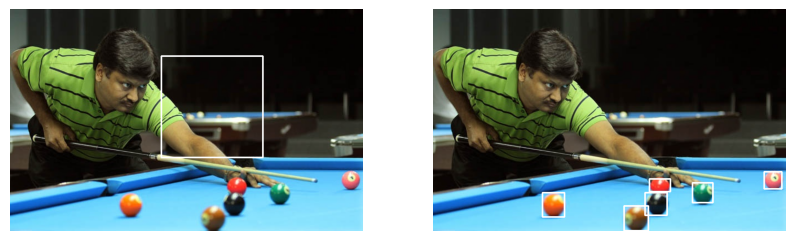

In [1413]:
plotPred(train_dataset[0], max_frames=1_000, pr=0.94)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 9, coefficient = 0.98


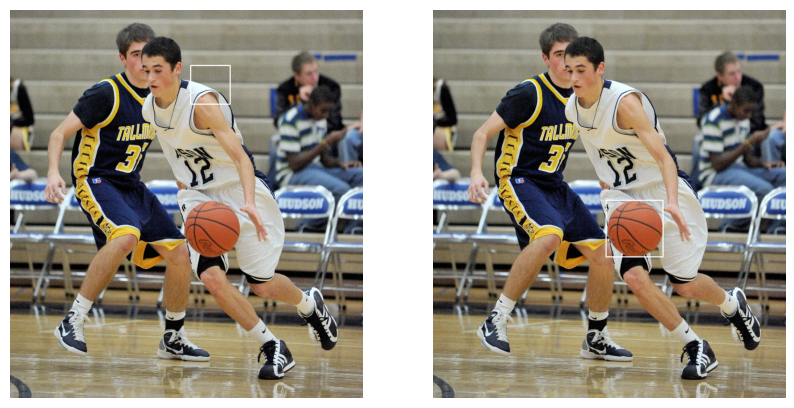

In [1414]:
plotPred(train_dataset[1], max_frames=1_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 1, coefficient = 0.9299999999999999


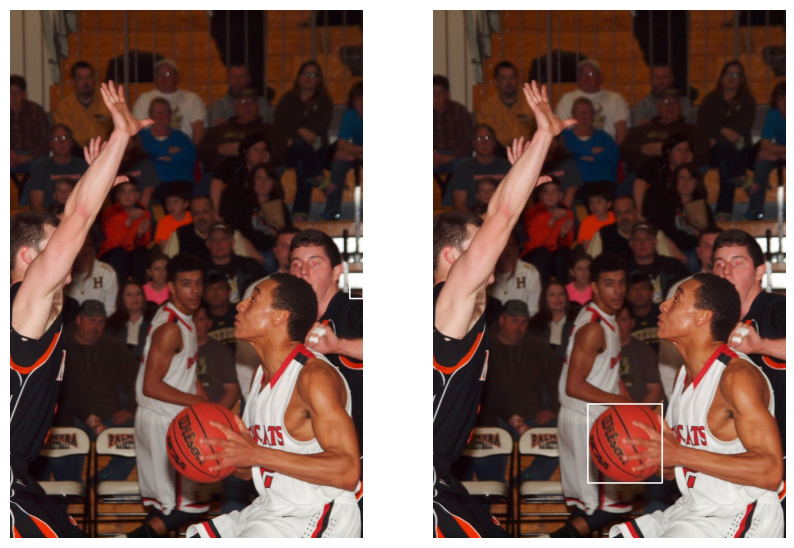

In [1415]:
plotPred(train_dataset[200], max_frames=1_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 1, coefficient = 0.95


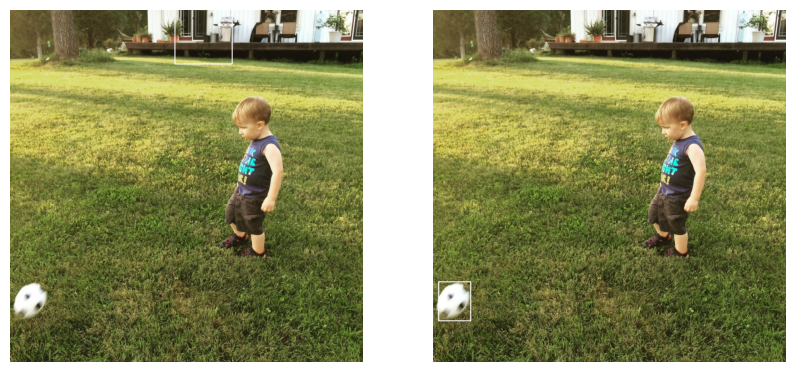

In [1416]:
plotPred(val_dataset[100], max_frames=1_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 8, coefficient = 0.96


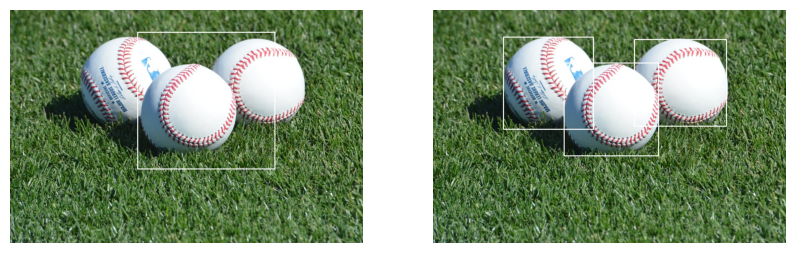

In [1417]:
plotPred(val_dataset[200], max_frames=1_000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].


len(true_frames) = 1, coefficient = 0.97


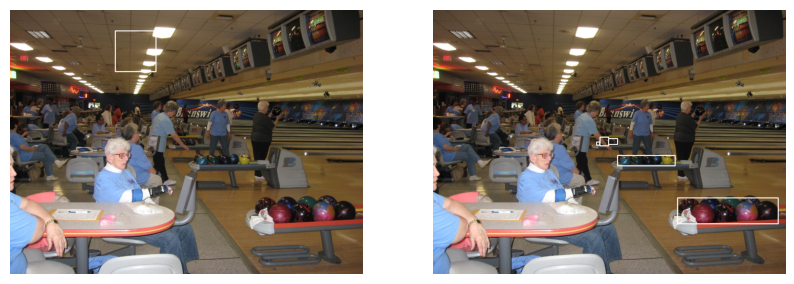

In [1418]:
plotPred(val_dataset[225], max_frames=1_000)

### Метрика

In [1440]:
def getGT(frames):
    gt = []
    for annot in frames['annot']:
        line = []
        for it in annot:
            line.append(it)
        line.append(0)
        line.append(0)
        gt.append(line.copy())
    return gt

In [1442]:
def getPREDS(frames):
    preds = []
    for i in frames['i']:
        line = []
        for coord in frames['coord'][i]:
            line.append(coord)
        line.append(0)
        line.append(frames['pred'][i])
        preds.append(line.copy())
    return preds

In [1465]:
class mAP:
    def __init__(self, norms=NonOriginalNonMaximumSuppression()):
        self._nonms = norms

    def _gt(self, frames):
        gt = []
        for annot in frames['annot']:
            line = []
            for it in annot:
                line.append(it)
            line.append(0)
            line.append(0)
            gt.append(line.copy())
        return np.array(gt)

    def _preds(self, frames):
        preds = []
        combined_frames, combined_coordinates = self._nonms._combine(frames['img'], frames['true_frames'], frames['true_coord'])
        for i in range(len(combined_coordinates)):
            line = []
            for coord in combined_coordinates[i]:
                line.append(coord)
            line.append(0)
            line.append(cnn.predict(combined_frames[i]).numpy()[0][0])
            preds.append(line.copy())
        return np.array(preds)

    def __call__(self, frames):
        gt = self._gt(frames)
        preds = self._preds(frames)
        metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=1)
        for i in range(10):
            metric_fn.add(preds, gt)
        print(f"validation mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

metric_mAP = mAP()

In [1466]:
metric_mAP(frames)

validation mAP in all points: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05882353..180.0].


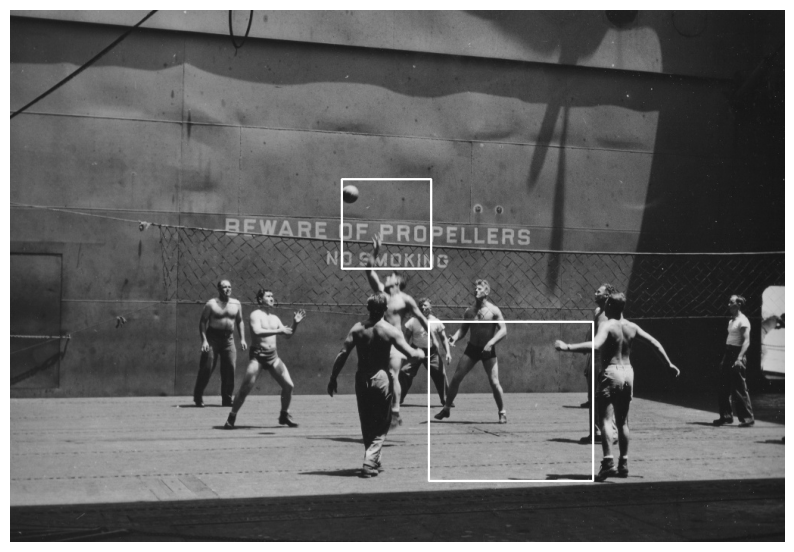

In [1467]:
plot_images(nonms(frames))

### Вывод

1. На практике такое применять нельзя.

2. В целом многих ошибок детекции можно было бы избежать, если бы на этапе извлечения данных, были бы взяты более расширенные картинки, то есть в больших границах, а шумы были бы наложены таким образом, чтобы оргинал сохранился. И в идеале надо было бы произвести, что то вроде фильтрации изорбажния для обучения, чтобы не было например чисто *цветных* картинок
    1. Так же даже если бы оставлять все как есть VGG-16 показала бы себя лучше чем то, что было использовано

3. Алогоритм RegionSplit оказался не удачным, извлекать регионы центрами которых является контур объекта на бумаге хорошая идея, но в реальности не у всех объектов мяча контур впринципе строился и как итог возникали ошибки.
   1. Как идеи брать не контур обхекта, а его ЧБ и из этих точек выбирать `frames`, но:
       1. Все еще сохраняется вероятность *промахнутся*
       2. Объект может слится с фоном и все усилия опять напрасны
       3. Могут быть шумы

4. К `NMS` вопросов нету, единственное только рациональным было еще проводить операцию сжатия, чтобы не возникал ситуаций, когда объект попал в поле зрения, а с ним еще лишние данные. Но для этого надо будет еще раз делать `predict`, чтобы случайно не удалить полезную информацию -> это влечет за собой дополнительные затраты по времени

В целом подводя общий итог картинка ниже лучше всего говорит о полученной модели

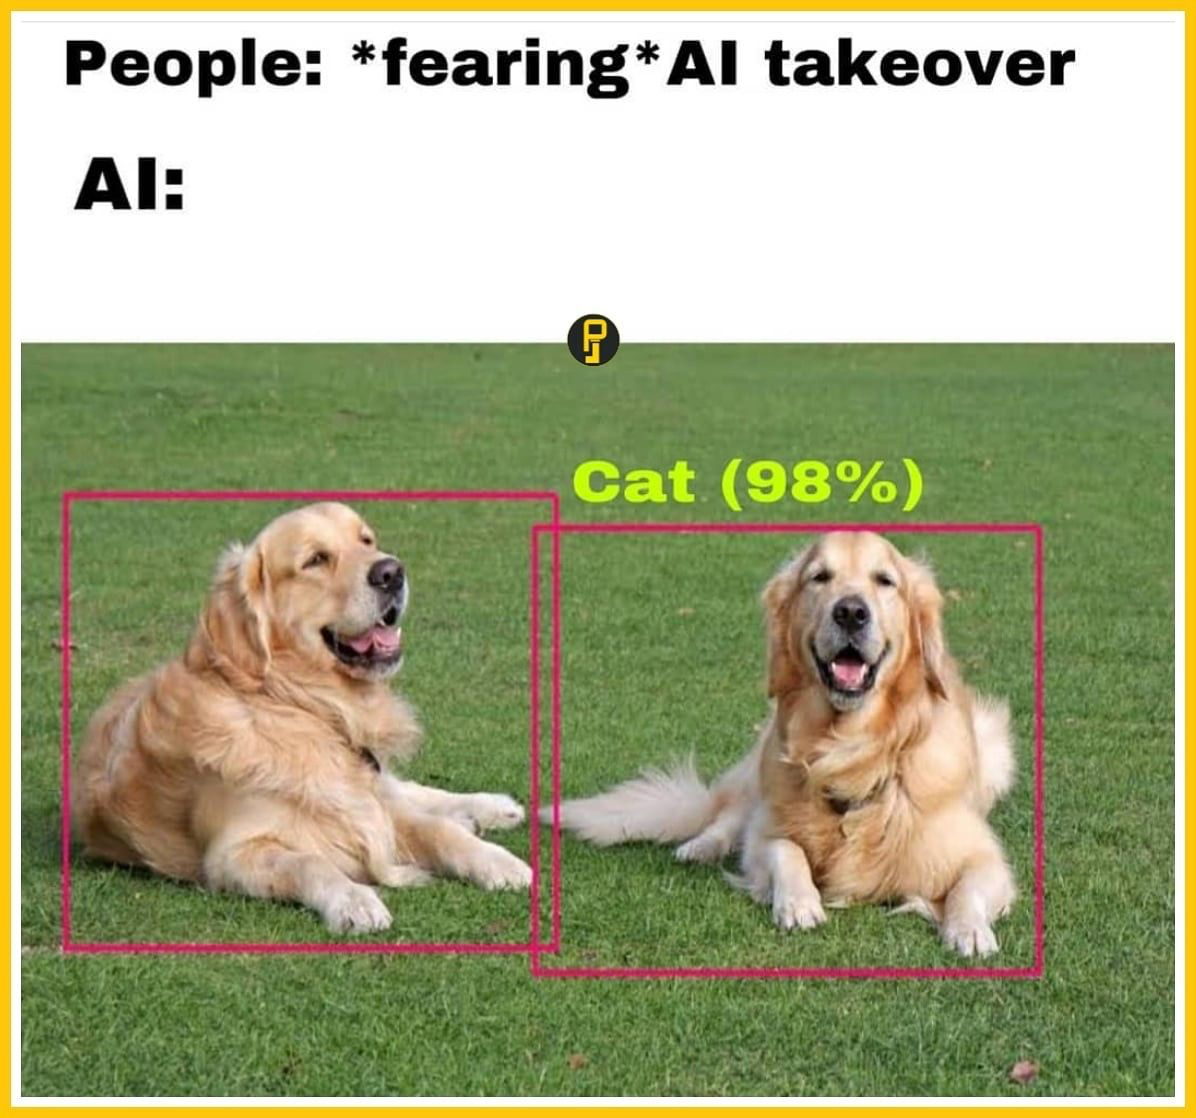